## The models being compared are Model 1 and Model 5

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

# Model 1

In [2]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_fc1 = nn.Linear(128*8*8, 512)
        self.enc_fc2_mean = nn.Linear(512, 128)
        self.enc_fc2_logvar = nn.Linear(512, 128)
        
        # Decoder
        self.dec_fc1 = nn.Linear(128, 512)
        self.dec_fc2 = nn.Linear(512, 128*8*8)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        
    def encode(self, x):
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = h.view(-1, 128*8*8)
        h = torch.relu(self.enc_fc1(h))
        return self.enc_fc2_mean(h), self.enc_fc2_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        h = torch.relu(self.dec_fc2(h))
        h = h.view(-1, 128, 8, 8)
        h = torch.relu(self.dec_conv1(h))
        return torch.tanh(self.dec_conv2(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [23]:
# Initialize the model, optimizer and loss function
model_1 = VAE()
optimizer = optim.Adam(model_1.parameters(), lr=1e-3)

In [24]:
# Training function
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item()/len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss/len(train_loader.dataset):.4f}')

In [25]:
# Training loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 736.050781
Train Epoch: 1 [6400/50000 (13%)]	Loss: 780.883301
Train Epoch: 1 [12800/50000 (26%)]	Loss: 801.352966
Train Epoch: 1 [19200/50000 (38%)]	Loss: 815.055420
Train Epoch: 1 [25600/50000 (51%)]	Loss: 779.438232
Train Epoch: 1 [32000/50000 (64%)]	Loss: 865.276306
Train Epoch: 1 [38400/50000 (77%)]	Loss: 815.893860
Train Epoch: 1 [44800/50000 (90%)]	Loss: 740.417725
====> Epoch: 1 Average loss: 791.9380
Train Epoch: 2 [0/50000 (0%)]	Loss: 728.889709
Train Epoch: 2 [6400/50000 (13%)]	Loss: 837.020813
Train Epoch: 2 [12800/50000 (26%)]	Loss: 720.902710
Train Epoch: 2 [19200/50000 (38%)]	Loss: 859.012207
Train Epoch: 2 [25600/50000 (51%)]	Loss: 749.029785
Train Epoch: 2 [32000/50000 (64%)]	Loss: 849.603455
Train Epoch: 2 [38400/50000 (77%)]	Loss: 753.757019
Train Epoch: 2 [44800/50000 (90%)]	Loss: 803.624451
====> Epoch: 2 Average loss: 791.9229
Train Epoch: 3 [0/50000 (0%)]	Loss: 773.627808
Train Epoch: 3 [6400/50000 (13%)]	Loss: 757.360596
Train 

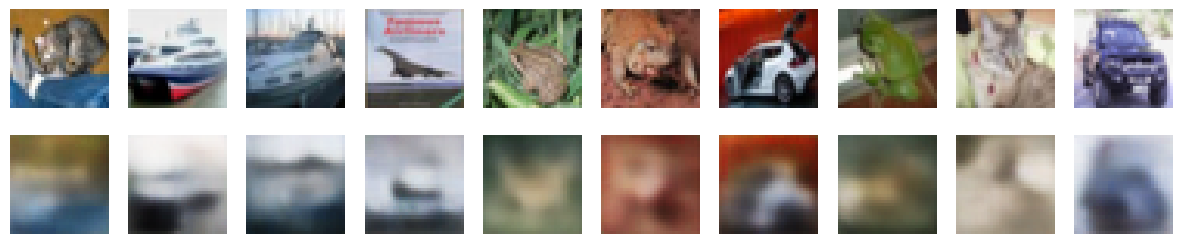

In [9]:
# Function to visualize the results
def visualize_reconstruction():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        recon, _, _ = model(data)
        
        fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
        for i in range(10):
            axes[0, i].imshow(data[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[1, i].imshow(recon[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()

# Visualize the results
visualize_reconstruction()

In [26]:
# evaluate the first model with inception score
model_1 = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Evaluating Model 1")
evaluate_inception_score(model_1, test_loader)

Evaluating Model 1
Inception Score: 1.0137668655896401 ± 0.0016487131066715633


# Model 2

In [10]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 128
num_epochs = 20  
latent_dim = 128  


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train(epoch)
    
visualize_reconstruction()

Train Epoch: 1 [0/50000 (0%)]	Loss: 794.952454
Train Epoch: 1 [12800/50000 (26%)]	Loss: 413.440887
Train Epoch: 1 [25600/50000 (51%)]	Loss: 358.159424
Train Epoch: 1 [38400/50000 (77%)]	Loss: 296.117737
====> Epoch: 1 Average loss: 395.4035
Train Epoch: 2 [0/50000 (0%)]	Loss: 262.767914
Train Epoch: 2 [12800/50000 (26%)]	Loss: 284.899933
Train Epoch: 2 [25600/50000 (51%)]	Loss: 254.826248
Train Epoch: 2 [38400/50000 (77%)]	Loss: 268.421021
====> Epoch: 2 Average loss: 272.0252
Train Epoch: 3 [0/50000 (0%)]	Loss: 252.340500
Train Epoch: 3 [12800/50000 (26%)]	Loss: 243.798141
Train Epoch: 3 [25600/50000 (51%)]	Loss: 256.980377
Train Epoch: 3 [38400/50000 (77%)]	Loss: 254.969391
====> Epoch: 3 Average loss: 246.1660
Train Epoch: 4 [0/50000 (0%)]	Loss: 236.071686
Train Epoch: 4 [12800/50000 (26%)]	Loss: 230.605286
Train Epoch: 4 [25600/50000 (51%)]	Loss: 233.115402
Train Epoch: 4 [38400/50000 (77%)]	Loss: 230.117035
====> Epoch: 4 Average loss: 233.5250
Train Epoch: 5 [0/50000 (0%)]	Loss: 

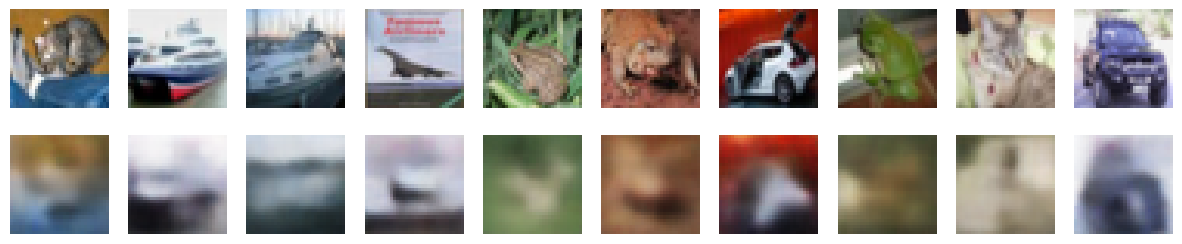

In [11]:
visualize_reconstruction()

# Model 3

Train Epoch: 1 [0/50000 (0%)]	Loss: 880.951599
Train Epoch: 1 [6400/50000 (13%)]	Loss: 539.614014
Train Epoch: 1 [12800/50000 (26%)]	Loss: 414.226349
Train Epoch: 1 [19200/50000 (38%)]	Loss: 337.673035
Train Epoch: 1 [25600/50000 (51%)]	Loss: 322.949463
Train Epoch: 1 [32000/50000 (64%)]	Loss: 301.046082
Train Epoch: 1 [38400/50000 (77%)]	Loss: 325.134827
Train Epoch: 1 [44800/50000 (90%)]	Loss: 310.500122
====> Epoch: 1 Average loss: 388.6281
Train Epoch: 2 [0/50000 (0%)]	Loss: 287.289154
Train Epoch: 2 [6400/50000 (13%)]	Loss: 274.690582
Train Epoch: 2 [12800/50000 (26%)]	Loss: 285.944366
Train Epoch: 2 [19200/50000 (38%)]	Loss: 293.153320
Train Epoch: 2 [25600/50000 (51%)]	Loss: 264.325317
Train Epoch: 2 [32000/50000 (64%)]	Loss: 277.404785
Train Epoch: 2 [38400/50000 (77%)]	Loss: 281.603058
Train Epoch: 2 [44800/50000 (90%)]	Loss: 243.750427
====> Epoch: 2 Average loss: 274.4565
Train Epoch: 3 [0/50000 (0%)]	Loss: 265.203522
Train Epoch: 3 [6400/50000 (13%)]	Loss: 262.154144
Train 

Train Epoch: 19 [6400/50000 (13%)]	Loss: 201.162231
Train Epoch: 19 [12800/50000 (26%)]	Loss: 214.482361
Train Epoch: 19 [19200/50000 (38%)]	Loss: 200.915314
Train Epoch: 19 [25600/50000 (51%)]	Loss: 210.581070
Train Epoch: 19 [32000/50000 (64%)]	Loss: 199.735901
Train Epoch: 19 [38400/50000 (77%)]	Loss: 191.400848
Train Epoch: 19 [44800/50000 (90%)]	Loss: 206.965240
====> Epoch: 19 Average loss: 194.9874
Train Epoch: 20 [0/50000 (0%)]	Loss: 184.209290
Train Epoch: 20 [6400/50000 (13%)]	Loss: 196.699890
Train Epoch: 20 [12800/50000 (26%)]	Loss: 201.853790
Train Epoch: 20 [19200/50000 (38%)]	Loss: 193.902420
Train Epoch: 20 [25600/50000 (51%)]	Loss: 183.121490
Train Epoch: 20 [32000/50000 (64%)]	Loss: 190.168030
Train Epoch: 20 [38400/50000 (77%)]	Loss: 189.361343
Train Epoch: 20 [44800/50000 (90%)]	Loss: 202.407257
====> Epoch: 20 Average loss: 194.2110


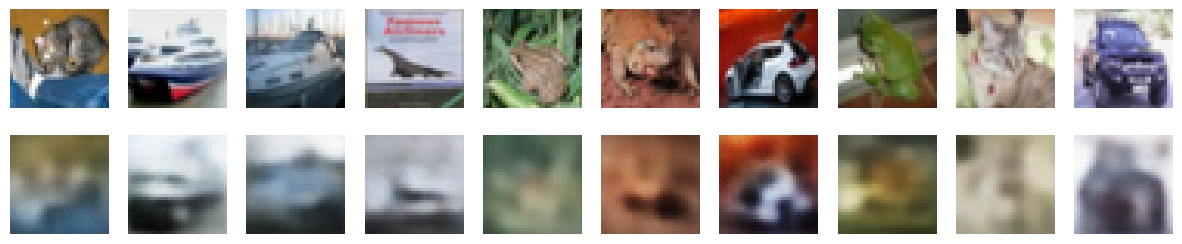

In [12]:
learning_rate = 1e-4  
batch_size = 64  
num_epochs = 20
latent_dim = 256  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train(epoch)
    
visualize_reconstruction()

# Model 4

Train Epoch: 1 [0/50000 (0%)]	Loss: 849.364441
Train Epoch: 1 [6400/50000 (13%)]	Loss: 417.165131
Train Epoch: 1 [12800/50000 (26%)]	Loss: 406.145172
Train Epoch: 1 [19200/50000 (38%)]	Loss: 355.130402
Train Epoch: 1 [25600/50000 (51%)]	Loss: 322.876007
Train Epoch: 1 [32000/50000 (64%)]	Loss: 317.703491
Train Epoch: 1 [38400/50000 (77%)]	Loss: 288.481934
Train Epoch: 1 [44800/50000 (90%)]	Loss: 273.830750
====> Epoch: 1 Average loss: 351.4684
Train Epoch: 2 [0/50000 (0%)]	Loss: 269.487030
Train Epoch: 2 [6400/50000 (13%)]	Loss: 275.391846
Train Epoch: 2 [12800/50000 (26%)]	Loss: 245.923279
Train Epoch: 2 [19200/50000 (38%)]	Loss: 282.464600
Train Epoch: 2 [25600/50000 (51%)]	Loss: 260.778168
Train Epoch: 2 [32000/50000 (64%)]	Loss: 256.133118
Train Epoch: 2 [38400/50000 (77%)]	Loss: 235.047867
Train Epoch: 2 [44800/50000 (90%)]	Loss: 229.937668
====> Epoch: 2 Average loss: 253.3274
Train Epoch: 3 [0/50000 (0%)]	Loss: 235.630066
Train Epoch: 3 [6400/50000 (13%)]	Loss: 251.339783
Train 

Train Epoch: 19 [6400/50000 (13%)]	Loss: 199.424820
Train Epoch: 19 [12800/50000 (26%)]	Loss: 190.423721
Train Epoch: 19 [19200/50000 (38%)]	Loss: 184.468048
Train Epoch: 19 [25600/50000 (51%)]	Loss: 202.414795
Train Epoch: 19 [32000/50000 (64%)]	Loss: 186.447098
Train Epoch: 19 [38400/50000 (77%)]	Loss: 188.233109
Train Epoch: 19 [44800/50000 (90%)]	Loss: 206.097916
====> Epoch: 19 Average loss: 197.6624
Train Epoch: 20 [0/50000 (0%)]	Loss: 197.304337
Train Epoch: 20 [6400/50000 (13%)]	Loss: 186.427490
Train Epoch: 20 [12800/50000 (26%)]	Loss: 195.998077
Train Epoch: 20 [19200/50000 (38%)]	Loss: 183.287125
Train Epoch: 20 [25600/50000 (51%)]	Loss: 196.689377
Train Epoch: 20 [32000/50000 (64%)]	Loss: 189.931778
Train Epoch: 20 [38400/50000 (77%)]	Loss: 198.449875
Train Epoch: 20 [44800/50000 (90%)]	Loss: 190.853119
====> Epoch: 20 Average loss: 197.0130
Train Epoch: 21 [0/50000 (0%)]	Loss: 199.580124
Train Epoch: 21 [6400/50000 (13%)]	Loss: 197.482376
Train Epoch: 21 [12800/50000 (26%)

Train Epoch: 37 [6400/50000 (13%)]	Loss: 185.459213
Train Epoch: 37 [12800/50000 (26%)]	Loss: 194.466370
Train Epoch: 37 [19200/50000 (38%)]	Loss: 199.046310
Train Epoch: 37 [25600/50000 (51%)]	Loss: 201.308075
Train Epoch: 37 [32000/50000 (64%)]	Loss: 194.949310
Train Epoch: 37 [38400/50000 (77%)]	Loss: 186.383179
Train Epoch: 37 [44800/50000 (90%)]	Loss: 202.892883
====> Epoch: 37 Average loss: 190.7691
Train Epoch: 38 [0/50000 (0%)]	Loss: 193.234482
Train Epoch: 38 [6400/50000 (13%)]	Loss: 186.374588
Train Epoch: 38 [12800/50000 (26%)]	Loss: 192.190399
Train Epoch: 38 [19200/50000 (38%)]	Loss: 177.703079
Train Epoch: 38 [25600/50000 (51%)]	Loss: 176.857880
Train Epoch: 38 [32000/50000 (64%)]	Loss: 189.791275
Train Epoch: 38 [38400/50000 (77%)]	Loss: 186.767792
Train Epoch: 38 [44800/50000 (90%)]	Loss: 185.120224
====> Epoch: 38 Average loss: 190.3509
Train Epoch: 39 [0/50000 (0%)]	Loss: 185.197037
Train Epoch: 39 [6400/50000 (13%)]	Loss: 185.088455
Train Epoch: 39 [12800/50000 (26%)

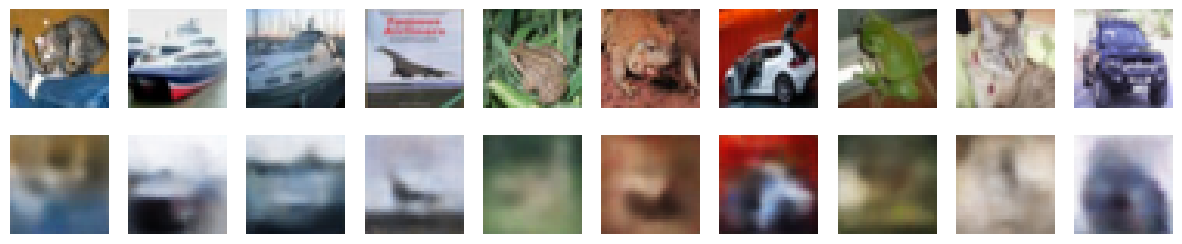

In [13]:
learning_rate = 1e-3 
batch_size = 64  
num_epochs = 50
latent_dim = 256  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train(epoch)
    
visualize_reconstruction()

# Model 5

Train Epoch: 1 [0/50000 (0%)]	Loss: 789.749573
Train Epoch: 1 [6400/50000 (13%)]	Loss: 456.769043
Train Epoch: 1 [12800/50000 (26%)]	Loss: 383.572266
Train Epoch: 1 [19200/50000 (38%)]	Loss: 350.144714
Train Epoch: 1 [25600/50000 (51%)]	Loss: 340.412964
Train Epoch: 1 [32000/50000 (64%)]	Loss: 363.456055
Train Epoch: 1 [38400/50000 (77%)]	Loss: 275.686096
Train Epoch: 1 [44800/50000 (90%)]	Loss: 288.173035
====> Epoch: 1 Average loss: 391.8684
Train Epoch: 2 [0/50000 (0%)]	Loss: 303.136627
Train Epoch: 2 [6400/50000 (13%)]	Loss: 295.142578
Train Epoch: 2 [12800/50000 (26%)]	Loss: 279.594055
Train Epoch: 2 [19200/50000 (38%)]	Loss: 291.210266
Train Epoch: 2 [25600/50000 (51%)]	Loss: 299.553253
Train Epoch: 2 [32000/50000 (64%)]	Loss: 259.952393
Train Epoch: 2 [38400/50000 (77%)]	Loss: 248.396729
Train Epoch: 2 [44800/50000 (90%)]	Loss: 286.880066
====> Epoch: 2 Average loss: 273.9908
Train Epoch: 3 [0/50000 (0%)]	Loss: 276.742004
Train Epoch: 3 [6400/50000 (13%)]	Loss: 264.735779
Train 

Train Epoch: 19 [6400/50000 (13%)]	Loss: 197.506256
Train Epoch: 19 [12800/50000 (26%)]	Loss: 191.753281
Train Epoch: 19 [19200/50000 (38%)]	Loss: 197.603119
Train Epoch: 19 [25600/50000 (51%)]	Loss: 191.814407
Train Epoch: 19 [32000/50000 (64%)]	Loss: 185.995163
Train Epoch: 19 [38400/50000 (77%)]	Loss: 196.708908
Train Epoch: 19 [44800/50000 (90%)]	Loss: 216.115326
====> Epoch: 19 Average loss: 194.3711
Train Epoch: 20 [0/50000 (0%)]	Loss: 197.676437
Train Epoch: 20 [6400/50000 (13%)]	Loss: 195.909973
Train Epoch: 20 [12800/50000 (26%)]	Loss: 203.779861
Train Epoch: 20 [19200/50000 (38%)]	Loss: 203.696381
Train Epoch: 20 [25600/50000 (51%)]	Loss: 198.211700
Train Epoch: 20 [32000/50000 (64%)]	Loss: 201.180786
Train Epoch: 20 [38400/50000 (77%)]	Loss: 198.098312
Train Epoch: 20 [44800/50000 (90%)]	Loss: 191.010712
====> Epoch: 20 Average loss: 193.5686
Train Epoch: 21 [0/50000 (0%)]	Loss: 184.611084
Train Epoch: 21 [6400/50000 (13%)]	Loss: 202.450714
Train Epoch: 21 [12800/50000 (26%)

Train Epoch: 37 [6400/50000 (13%)]	Loss: 186.583771
Train Epoch: 37 [12800/50000 (26%)]	Loss: 191.301636
Train Epoch: 37 [19200/50000 (38%)]	Loss: 171.207840
Train Epoch: 37 [25600/50000 (51%)]	Loss: 200.157364
Train Epoch: 37 [32000/50000 (64%)]	Loss: 185.200806
Train Epoch: 37 [38400/50000 (77%)]	Loss: 192.137115
Train Epoch: 37 [44800/50000 (90%)]	Loss: 200.211609
====> Epoch: 37 Average loss: 185.4615
Train Epoch: 38 [0/50000 (0%)]	Loss: 185.240829
Train Epoch: 38 [6400/50000 (13%)]	Loss: 178.960419
Train Epoch: 38 [12800/50000 (26%)]	Loss: 185.940689
Train Epoch: 38 [19200/50000 (38%)]	Loss: 175.662384
Train Epoch: 38 [25600/50000 (51%)]	Loss: 181.066803
Train Epoch: 38 [32000/50000 (64%)]	Loss: 184.172394
Train Epoch: 38 [38400/50000 (77%)]	Loss: 175.521240
Train Epoch: 38 [44800/50000 (90%)]	Loss: 187.012604
====> Epoch: 38 Average loss: 185.1758
Train Epoch: 39 [0/50000 (0%)]	Loss: 200.383377
Train Epoch: 39 [6400/50000 (13%)]	Loss: 178.905594
Train Epoch: 39 [12800/50000 (26%)

Train Epoch: 55 [6400/50000 (13%)]	Loss: 171.136978
Train Epoch: 55 [12800/50000 (26%)]	Loss: 179.482117
Train Epoch: 55 [19200/50000 (38%)]	Loss: 181.129791
Train Epoch: 55 [25600/50000 (51%)]	Loss: 177.811676
Train Epoch: 55 [32000/50000 (64%)]	Loss: 178.917099
Train Epoch: 55 [38400/50000 (77%)]	Loss: 178.296707
Train Epoch: 55 [44800/50000 (90%)]	Loss: 171.820816
====> Epoch: 55 Average loss: 181.0996
Train Epoch: 56 [0/50000 (0%)]	Loss: 189.932800
Train Epoch: 56 [6400/50000 (13%)]	Loss: 180.857727
Train Epoch: 56 [12800/50000 (26%)]	Loss: 181.613770
Train Epoch: 56 [19200/50000 (38%)]	Loss: 187.624527
Train Epoch: 56 [25600/50000 (51%)]	Loss: 175.722443
Train Epoch: 56 [32000/50000 (64%)]	Loss: 177.296631
Train Epoch: 56 [38400/50000 (77%)]	Loss: 174.535278
Train Epoch: 56 [44800/50000 (90%)]	Loss: 184.662277
====> Epoch: 56 Average loss: 180.8450
Train Epoch: 57 [0/50000 (0%)]	Loss: 184.381805
Train Epoch: 57 [6400/50000 (13%)]	Loss: 174.525467
Train Epoch: 57 [12800/50000 (26%)

Train Epoch: 73 [6400/50000 (13%)]	Loss: 178.990784
Train Epoch: 73 [12800/50000 (26%)]	Loss: 177.905014
Train Epoch: 73 [19200/50000 (38%)]	Loss: 184.931946
Train Epoch: 73 [25600/50000 (51%)]	Loss: 176.960052
Train Epoch: 73 [32000/50000 (64%)]	Loss: 170.409225
Train Epoch: 73 [38400/50000 (77%)]	Loss: 171.245224
Train Epoch: 73 [44800/50000 (90%)]	Loss: 182.513687
====> Epoch: 73 Average loss: 177.9625
Train Epoch: 74 [0/50000 (0%)]	Loss: 166.929352
Train Epoch: 74 [6400/50000 (13%)]	Loss: 170.194702
Train Epoch: 74 [12800/50000 (26%)]	Loss: 172.786957
Train Epoch: 74 [19200/50000 (38%)]	Loss: 181.049057
Train Epoch: 74 [25600/50000 (51%)]	Loss: 181.453735
Train Epoch: 74 [32000/50000 (64%)]	Loss: 185.796997
Train Epoch: 74 [38400/50000 (77%)]	Loss: 180.233398
Train Epoch: 74 [44800/50000 (90%)]	Loss: 179.036911
====> Epoch: 74 Average loss: 177.9121
Train Epoch: 75 [0/50000 (0%)]	Loss: 169.576172
Train Epoch: 75 [6400/50000 (13%)]	Loss: 181.138229
Train Epoch: 75 [12800/50000 (26%)

Train Epoch: 91 [6400/50000 (13%)]	Loss: 173.649902
Train Epoch: 91 [12800/50000 (26%)]	Loss: 178.728470
Train Epoch: 91 [19200/50000 (38%)]	Loss: 181.543640
Train Epoch: 91 [25600/50000 (51%)]	Loss: 160.489746
Train Epoch: 91 [32000/50000 (64%)]	Loss: 181.300415
Train Epoch: 91 [38400/50000 (77%)]	Loss: 176.923553
Train Epoch: 91 [44800/50000 (90%)]	Loss: 169.879608
====> Epoch: 91 Average loss: 175.4435
Train Epoch: 92 [0/50000 (0%)]	Loss: 168.059647
Train Epoch: 92 [6400/50000 (13%)]	Loss: 167.891937
Train Epoch: 92 [12800/50000 (26%)]	Loss: 157.708344
Train Epoch: 92 [19200/50000 (38%)]	Loss: 173.153931
Train Epoch: 92 [25600/50000 (51%)]	Loss: 168.127731
Train Epoch: 92 [32000/50000 (64%)]	Loss: 180.671539
Train Epoch: 92 [38400/50000 (77%)]	Loss: 171.397186
Train Epoch: 92 [44800/50000 (90%)]	Loss: 169.274612
====> Epoch: 92 Average loss: 175.3312
Train Epoch: 93 [0/50000 (0%)]	Loss: 171.857391
Train Epoch: 93 [6400/50000 (13%)]	Loss: 176.243439
Train Epoch: 93 [12800/50000 (26%)

====> Epoch: 108 Average loss: 173.4928
Train Epoch: 109 [0/50000 (0%)]	Loss: 172.712997
Train Epoch: 109 [6400/50000 (13%)]	Loss: 179.424438
Train Epoch: 109 [12800/50000 (26%)]	Loss: 168.681458
Train Epoch: 109 [19200/50000 (38%)]	Loss: 169.658875
Train Epoch: 109 [25600/50000 (51%)]	Loss: 170.244949
Train Epoch: 109 [32000/50000 (64%)]	Loss: 159.007523
Train Epoch: 109 [38400/50000 (77%)]	Loss: 179.035477
Train Epoch: 109 [44800/50000 (90%)]	Loss: 157.569183
====> Epoch: 109 Average loss: 173.3672
Train Epoch: 110 [0/50000 (0%)]	Loss: 174.636856
Train Epoch: 110 [6400/50000 (13%)]	Loss: 174.087738
Train Epoch: 110 [12800/50000 (26%)]	Loss: 169.081039
Train Epoch: 110 [19200/50000 (38%)]	Loss: 175.532745
Train Epoch: 110 [25600/50000 (51%)]	Loss: 175.006668
Train Epoch: 110 [32000/50000 (64%)]	Loss: 176.949493
Train Epoch: 110 [38400/50000 (77%)]	Loss: 173.312683
Train Epoch: 110 [44800/50000 (90%)]	Loss: 181.756027
====> Epoch: 110 Average loss: 173.2064
Train Epoch: 111 [0/50000 (0

Train Epoch: 126 [32000/50000 (64%)]	Loss: 172.007690
Train Epoch: 126 [38400/50000 (77%)]	Loss: 188.496460
Train Epoch: 126 [44800/50000 (90%)]	Loss: 176.617554
====> Epoch: 126 Average loss: 171.5935
Train Epoch: 127 [0/50000 (0%)]	Loss: 168.654480
Train Epoch: 127 [6400/50000 (13%)]	Loss: 162.498642
Train Epoch: 127 [12800/50000 (26%)]	Loss: 170.180496
Train Epoch: 127 [19200/50000 (38%)]	Loss: 176.284576
Train Epoch: 127 [25600/50000 (51%)]	Loss: 169.680008
Train Epoch: 127 [32000/50000 (64%)]	Loss: 184.281372
Train Epoch: 127 [38400/50000 (77%)]	Loss: 164.068542
Train Epoch: 127 [44800/50000 (90%)]	Loss: 178.387497
====> Epoch: 127 Average loss: 171.4492
Train Epoch: 128 [0/50000 (0%)]	Loss: 169.392609
Train Epoch: 128 [6400/50000 (13%)]	Loss: 172.228867
Train Epoch: 128 [12800/50000 (26%)]	Loss: 162.720032
Train Epoch: 128 [19200/50000 (38%)]	Loss: 169.899780
Train Epoch: 128 [25600/50000 (51%)]	Loss: 177.758118
Train Epoch: 128 [32000/50000 (64%)]	Loss: 176.959732
Train Epoch: 1

Train Epoch: 144 [12800/50000 (26%)]	Loss: 172.999969
Train Epoch: 144 [19200/50000 (38%)]	Loss: 176.380676
Train Epoch: 144 [25600/50000 (51%)]	Loss: 167.903030
Train Epoch: 144 [32000/50000 (64%)]	Loss: 182.801743
Train Epoch: 144 [38400/50000 (77%)]	Loss: 183.617065
Train Epoch: 144 [44800/50000 (90%)]	Loss: 159.401917
====> Epoch: 144 Average loss: 169.9966
Train Epoch: 145 [0/50000 (0%)]	Loss: 172.740707
Train Epoch: 145 [6400/50000 (13%)]	Loss: 178.085617
Train Epoch: 145 [12800/50000 (26%)]	Loss: 169.525101
Train Epoch: 145 [19200/50000 (38%)]	Loss: 166.790970
Train Epoch: 145 [25600/50000 (51%)]	Loss: 170.928650
Train Epoch: 145 [32000/50000 (64%)]	Loss: 184.085281
Train Epoch: 145 [38400/50000 (77%)]	Loss: 169.945480
Train Epoch: 145 [44800/50000 (90%)]	Loss: 171.577789
====> Epoch: 145 Average loss: 169.9218
Train Epoch: 146 [0/50000 (0%)]	Loss: 175.947205
Train Epoch: 146 [6400/50000 (13%)]	Loss: 166.577667
Train Epoch: 146 [12800/50000 (26%)]	Loss: 168.642883
Train Epoch: 1

====> Epoch: 161 Average loss: 168.6591
Train Epoch: 162 [0/50000 (0%)]	Loss: 162.795395
Train Epoch: 162 [6400/50000 (13%)]	Loss: 160.662689
Train Epoch: 162 [12800/50000 (26%)]	Loss: 166.298965
Train Epoch: 162 [19200/50000 (38%)]	Loss: 169.088577
Train Epoch: 162 [25600/50000 (51%)]	Loss: 154.402740
Train Epoch: 162 [32000/50000 (64%)]	Loss: 168.654083
Train Epoch: 162 [38400/50000 (77%)]	Loss: 173.931885
Train Epoch: 162 [44800/50000 (90%)]	Loss: 172.835602
====> Epoch: 162 Average loss: 168.5652
Train Epoch: 163 [0/50000 (0%)]	Loss: 157.290741
Train Epoch: 163 [6400/50000 (13%)]	Loss: 174.020584
Train Epoch: 163 [12800/50000 (26%)]	Loss: 167.239655
Train Epoch: 163 [19200/50000 (38%)]	Loss: 154.738052
Train Epoch: 163 [25600/50000 (51%)]	Loss: 174.259048
Train Epoch: 163 [32000/50000 (64%)]	Loss: 172.546082
Train Epoch: 163 [38400/50000 (77%)]	Loss: 180.199036
Train Epoch: 163 [44800/50000 (90%)]	Loss: 178.383911
====> Epoch: 163 Average loss: 168.5565
Train Epoch: 164 [0/50000 (0

Train Epoch: 179 [32000/50000 (64%)]	Loss: 173.823776
Train Epoch: 179 [38400/50000 (77%)]	Loss: 169.838959
Train Epoch: 179 [44800/50000 (90%)]	Loss: 164.054657
====> Epoch: 179 Average loss: 167.4457
Train Epoch: 180 [0/50000 (0%)]	Loss: 166.767822
Train Epoch: 180 [6400/50000 (13%)]	Loss: 165.904663
Train Epoch: 180 [12800/50000 (26%)]	Loss: 154.200165
Train Epoch: 180 [19200/50000 (38%)]	Loss: 166.243347
Train Epoch: 180 [25600/50000 (51%)]	Loss: 163.041855
Train Epoch: 180 [32000/50000 (64%)]	Loss: 163.035568
Train Epoch: 180 [38400/50000 (77%)]	Loss: 166.679718
Train Epoch: 180 [44800/50000 (90%)]	Loss: 176.613205
====> Epoch: 180 Average loss: 167.3159
Train Epoch: 181 [0/50000 (0%)]	Loss: 163.296127
Train Epoch: 181 [6400/50000 (13%)]	Loss: 163.286438
Train Epoch: 181 [12800/50000 (26%)]	Loss: 167.602295
Train Epoch: 181 [19200/50000 (38%)]	Loss: 184.107849
Train Epoch: 181 [25600/50000 (51%)]	Loss: 167.658752
Train Epoch: 181 [32000/50000 (64%)]	Loss: 174.367859
Train Epoch: 1

Train Epoch: 197 [12800/50000 (26%)]	Loss: 158.295135
Train Epoch: 197 [19200/50000 (38%)]	Loss: 166.230621
Train Epoch: 197 [25600/50000 (51%)]	Loss: 160.710876
Train Epoch: 197 [32000/50000 (64%)]	Loss: 161.118668
Train Epoch: 197 [38400/50000 (77%)]	Loss: 176.223480
Train Epoch: 197 [44800/50000 (90%)]	Loss: 158.012054
====> Epoch: 197 Average loss: 166.1781
Train Epoch: 198 [0/50000 (0%)]	Loss: 165.385437
Train Epoch: 198 [6400/50000 (13%)]	Loss: 160.650726
Train Epoch: 198 [12800/50000 (26%)]	Loss: 162.734070
Train Epoch: 198 [19200/50000 (38%)]	Loss: 168.114655
Train Epoch: 198 [25600/50000 (51%)]	Loss: 167.343018
Train Epoch: 198 [32000/50000 (64%)]	Loss: 172.803360
Train Epoch: 198 [38400/50000 (77%)]	Loss: 167.183914
Train Epoch: 198 [44800/50000 (90%)]	Loss: 171.376892
====> Epoch: 198 Average loss: 166.1411
Train Epoch: 199 [0/50000 (0%)]	Loss: 172.873718
Train Epoch: 199 [6400/50000 (13%)]	Loss: 161.159485
Train Epoch: 199 [12800/50000 (26%)]	Loss: 175.136963
Train Epoch: 1

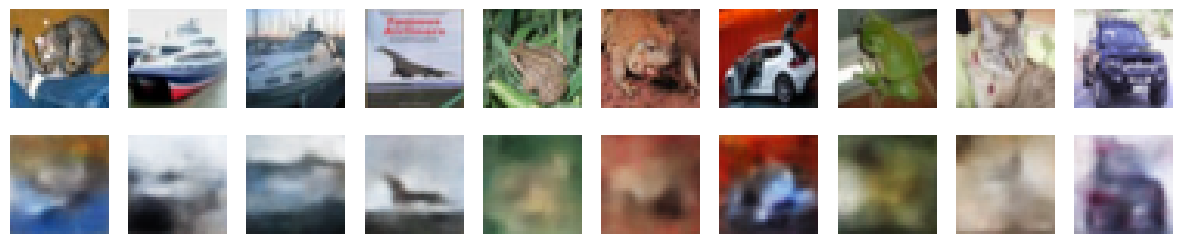

In [14]:
learning_rate = 1e-4
batch_size = 64  
num_epochs = 200
latent_dim = 256  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train(epoch)
    
visualize_reconstruction()

# Evaluate models using inception score

In [20]:
# Inception Score calculation
def inception_score(images, cuda=True, batch_size=32, splits=10):
    N = len(images)
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear')
    
    def get_pred(x):
        if cuda:
            x = x.cuda()
        x = up(x)
        x = inception_model(x)
        return nn.functional.softmax(x, dim=1).data.cpu().numpy()

    if cuda:
        inception_model = inception_model.cuda()

    preds = np.zeros((N, 1000))
    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size]
        preds[i:i + batch_size] = get_pred(batch)

    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Evaluate models using Inception Score
def evaluate_inception_score(model, test_loader):
    model.eval()
    images = []
    with torch.no_grad():
        for _ in range(10):  
            data, _ = next(iter(test_loader))
            recon, _, _ = model(data)
            images.append(recon.cpu())
    images = torch.cat(images, dim=0)
    score, std = inception_score(images, cuda=torch.cuda.is_available())
    print(f'Inception Score: {score} ± {std}')

In [22]:
# Evaluate the fifth model for inception score
print("Evaluating Model 5")
evaluate_inception_score(model, test_loader)

Evaluating Model 5
Inception Score: 1.0191729312738547 ± 0.0016442285289189112
